In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
os.environ["NUMBA_ENABLE_CUDASIM"] = "1"
from numba import jit, int32, int64, float64, njit, vectorize, cuda

## Exercise 1

Create a vectorized version of log and exp math function for 1D array A = [2, 5, 10, 3, 8]

Results should be: 
+ [0.6931472 1.609438  2.3025851 1.0986123 2.0794415]
+ [7.3890562e+00 1.4841316e+02 2.2026465e+04 2.0085537e+01 2.9809580e+03]

In [4]:
@vectorize([float64(float64)], target='cpu', fastmath=True) #cpu for me is faster
def vec_log(x):
    c =  np.log(x)
    return c

A=[2,5,10,3,8]

%timeit np.log(A)
%timeit vec_log(A)

print (vec_log(A))

2.55 µs ± 147 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.41 µs ± 37.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
[0.69314718 1.60943791 2.30258509 1.09861229 2.07944154]


In [5]:
@vectorize([float64(float64)], target='cpu', fastmath=True) #cpu for me is faster
def vec_exp(x):
    c =  np.exp(x)
    return c

A=[2,5,10,3,8]

%timeit np.exp(A)
%timeit vec_exp(A)

print (vec_exp(A))

2.56 µs ± 57.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
2.43 µs ± 48.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
[7.38905610e+00 1.48413159e+02 2.20264658e+04 2.00855369e+01
 2.98095799e+03]


## Exerice 2
Compute the value of a Gaussian probability density function at $x$ with $mean = 1$, $\sigma = 1$, lower and upper bound in $(-3, 3)$ and $size = 100000$

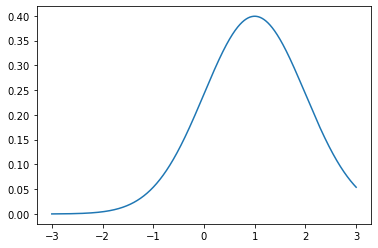

934 µs ± 33 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
N = 100000
mean = 1
sig = 1
x=np.linspace(-3,3,N)
values =[]

def gauss (x, mean, sig):
    xx = np.exp(-(((x-mean)/sig)**2/2))/(sig*np.sqrt(2*np.pi))
    return xx

values = gauss(x,mean,sig)
plt.plot (x, values)
plt.show ()

%timeit gauss(x,mean,sig)

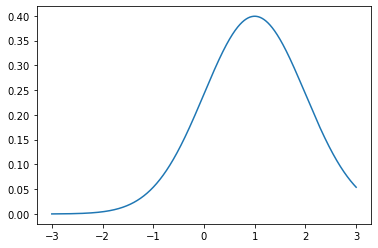

315 µs ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
N = 100000
mean = 1
sig = 1
x=np.linspace(-3,3,N)
values =[]

@jit
def gauss_jit (x, mean, sig):
    xx = np.exp(-(((x-mean)/sig)**2/2))/(sig*np.sqrt(2*np.pi))
    return xx

values = gauss_jit(x,mean,sig)
plt.plot (x, values)
plt.show ()

%timeit gauss_jit(x,mean,sig)

## Exercise 3

Create a "zero suppression" function. A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise. 
Plot the data before and after the application of the zero_suppress function.

$thresold = 15$

In [20]:
n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
data = ((pulses * 300) + noise).astype(np.int16)
data_new=np.zeros_like(data)
data_jit=np.zeros_like(data)

def zeros (empty, limit):
    empty [:]= np.where(data>limit, data, 0)
    
zeros (data_new, 15)

@jit
def zeros_jit (empty, limit):
    empty [:]= np.where(data>limit, data, 0)
    
zeros_jit(data_jit, 15)
    

In [21]:
%timeit zeros (data_new, 15)
%timeit zeros_jit(data_jit, 15)

229 µs ± 13.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
205 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


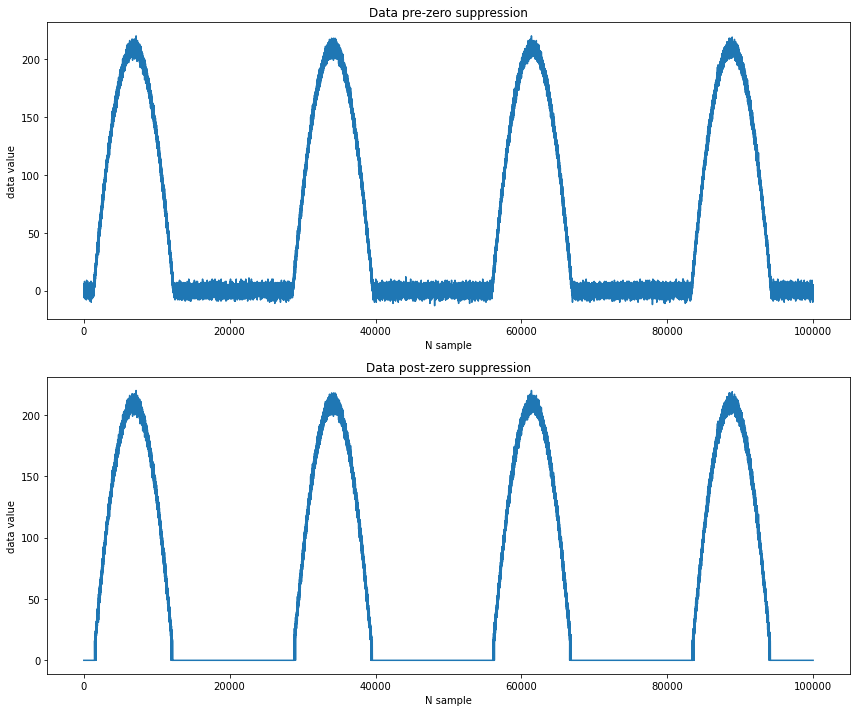

In [22]:
fig, ax = plt.subplots(nrows=2, figsize=(12, 10))
ax[0].plot(data)
ax[0].set_xlabel('N sample')
ax[0].set_ylabel('data value')
ax[0].set_title('Data pre-zero suppression')

ax[1].plot(data_jit)
ax[1].set_xlabel('N sample')
ax[1].set_ylabel('data value')
ax[1].set_title('Data post-zero suppression')

plt.tight_layout()

## Exercise 4

Calculate the Sigmoid kernel between the matrix X and Y defined as below. The Sigmoid kernel is defined as:

$k(x,y) = \tanh(\alpha x^T y + c) $

In [124]:
alpha = 1
c = 0

X = np.random.rand(3,3)
Y = np.random.rand(3,3)
Z = X.T*Y

print (X)
print (Y)
print (Z, '\n')

print (np.tanh(Z)) #check

@cuda.jit
def increment_kernel(io_array):
    #pos = cuda.grid(1)
    row, col = cuda.grid(2) # For 2D array
    if row < io_array.shape[0] and col < io_array.shape[1]:
        io_array[row][col] = np.tanh(alpha*io_array[row][col]+c)

# Create the data array - usually initialized some other way
data = Z

# Set the number of threads in a block
threadsperblock = (3, 3)

# Calculate the number of thread blocks in the grid
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Now start the kernel
increment_kernel[blockspergrid, threadsperblock](Z)

# Print the result
print(data)

[[0.43166497 0.90997555 0.73085082]
 [0.80881197 0.97098102 0.55978047]
 [0.73610426 0.03832382 0.70872182]]
[[0.29139524 0.74561726 0.99551233]
 [0.29712842 0.49636064 0.50935307]
 [0.67717669 0.19554226 0.8877151 ]]
[[0.12578512 0.60306416 0.73280087]
 [0.27037959 0.48195676 0.01952036]
 [0.49491514 0.10946074 0.62914306]] 

[[0.1251259  0.53922637 0.6247759 ]
 [0.26397801 0.44780934 0.01951788]
 [0.4581088  0.10902565 0.55746186]]
[[0.1251259  0.53922637 0.6247759 ]
 [0.26397801 0.44780934 0.01951788]
 [0.4581088  0.10902565 0.55746186]]


## Exercise 5

Create a kernel function similar to the ```double_kernel``` see during the lecture and create a new function that takes a 3 dimensional matrix as input calculating the $cos$ for each element and then returns the result. The shape of the matrix must be $256X256X256$. The matrix can be randomly generated

In [34]:
@cuda.jit (float64(float64, float64, float64))
def double_kernel_3D(io_array):
    row, col, hig = cuda.grid(3)
    if row < io_array.shape[0] and col < io_array.shape[1] and hig < io_array.shape[2]:
        io_array[row][col][hig] = np.cos(io_array[row][col][hig])

data = np.random.rand(64,64,64)
#DONE with 64 instead of 256

threadsperblock = (8, 4, 2) #ThreadsPerBlock must be a divisor of the data dimension: 1024/ 64 / 16 = 1
blockspergrid_x = int(math.ceil(data.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(data.shape[1] / threadsperblock[1]))
blockspergrid_z = int(math.ceil(data.shape[2] / threadsperblock[2]))
blockspergrid = (blockspergrid_x, blockspergrid_y, blockspergrid_z)

double_kernel_3D[blockspergrid, threadsperblock](data)
print(data)

[[[0.94700745 0.86039446 0.78500965 ... 0.56050606 0.76463728 0.78922968]
  [0.76021772 0.9511471  0.99359674 ... 0.88841948 0.96894231 0.68438612]
  [0.99511843 0.71013972 0.76436492 ... 0.61289083 0.86326304 0.87646961]
  ...
  [0.98943235 0.80763322 0.86089046 ... 0.64070184 0.77415169 0.68080189]
  [0.91018597 0.9379527  0.78032545 ... 0.57666184 0.6561864  0.59169619]
  [0.70934737 0.98837207 0.98872997 ... 0.6412634  0.94702667 0.6655066 ]]

 [[0.70749479 0.73464873 0.6271937  ... 0.9511711  0.88064729 0.87846546]
  [0.77372783 0.84163607 0.99306839 ... 0.97815741 0.57202641 0.72135007]
  [0.68690129 0.8655519  0.80572261 ... 0.65544478 0.81736484 0.95112165]
  ...
  [0.99811507 0.68604562 0.97324256 ... 0.62045044 0.72969141 0.88074865]
  [0.86533772 0.73812407 0.89209658 ... 0.99903453 0.92918363 0.75075069]
  [0.99083435 0.57618495 0.972273   ... 0.99975351 0.9811981  0.93220494]]

 [[0.95915338 0.93070706 0.62556318 ... 0.94865109 0.92880989 0.85901203]
  [0.98906191 0.933431

## Exercise 6

Create a matrix multiplication kernel function, called ```matmul``` that takes as input two 2D matrices:
+ A of shape $24x12$
+ B of shape $12x22$
and that computes the multiplication and put the results into a third matrix C of shape $24x12$

A and B must be randomly generated and only int values are allowed.


In [28]:
from __future__ import division
from numba import cuda
import numpy
import math

@cuda.jit (float64(int32, int32, int32))
def matmul(A, B, C):
    ###Perform matrix multiplication of C = A * B
    row, col = cuda.grid(2)
    if row < C.shape[0] and col < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[row, k] * B[k, col]
        C[row, col] = tmp

# Initialize the data arrays
A = np.random.rand(24,12)
B = np.random.rand(12,22)
C = np.zeros ((24,22))

# Configure the blocks
threadsperblock = (6,4)
blockspergrid_x = int(math.ceil(A.shape[0] / threadsperblock[0]))
blockspergrid_y = int(math.ceil(B.shape[1] / threadsperblock[1]))
blockspergrid = (blockspergrid_x, blockspergrid_y)

matmul[blockspergrid, threadsperblock](A,B,C)
print(C)

[[3.50382006 2.4758568  2.75608878 2.70453347 2.43640818 2.40388009
  3.42314952 2.37961044 3.37458549 3.35308876 2.91587708 3.05008284
  3.16157115 2.66609902 3.27187535 3.37082548 3.5439278  3.35025594
  2.9077346  2.94823564 2.67100981 2.25207412]
 [4.57075561 3.18712294 2.83896887 3.09217553 2.39151279 2.82810897
  3.65405594 3.06795948 3.7759489  3.73781607 3.08201637 3.6983073
  3.35464865 3.33625081 3.40303343 3.34718727 4.11566196 3.64189588
  3.51060105 3.05687433 3.20013653 2.69793056]
 [4.55264358 3.63599556 3.33291071 3.36224871 3.17181582 2.66019608
  4.14599043 3.61502174 4.20958524 4.08997575 4.36638935 4.46546811
  3.86291605 2.98147284 4.1213523  4.25282076 4.11450729 4.33153315
  3.70683026 3.91344552 3.78516639 3.29729419]
 [3.79716025 3.28496369 2.60587452 2.46566021 2.97310661 2.34921873
  3.22607928 2.97101408 3.59427979 3.10035351 3.29347202 3.80690264
  2.97193677 2.32753548 3.39728687 3.24994855 2.89637426 3.42879469
  3.05817793 3.12640397 2.99541717 2.5206392